In [1]:
from glob import glob
from matplotlib import pylab as plt
import torch

from odenet import refine_train
from odenet import ode_models
from odenet import datasets

In [2]:
dirs = glob('results/odenet_*')
results = { name: torch.load(name) for name in dirs }

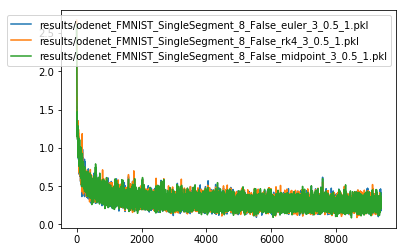

In [3]:
for name, result in results.items():
    plt.plot(result.losses, label=name)
plt.legend()

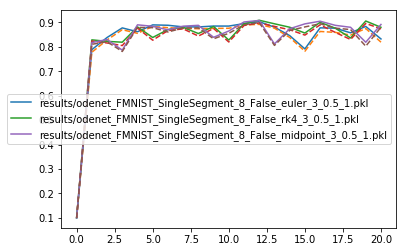

In [4]:
for name, result in results.items():
    plt.plot(result.train_acc, label=name)
    plt.plot(result.test_acc, '--')
plt.legend()

In [11]:
mod = result.model_list[0]
mod

ODEResNet_SingleSegment(
  (net): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ODEBlock(
      (net): ShallowConv2DODE(
        (L1): Conv2DODE()
        (L2): Conv2DODE()
      )
    )
    (4): Conv2d(8, 16, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ODEBlock(
      (net): ShallowConv2DODE(
        (L1): Conv2DODE()
        (L2): Conv2DODE()
      )
    )
    (7): Conv2d(16, 32, kernel_size=(1, 1), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ODEBlock(
      (net): ShallowConv2DODE(
        (L1): Conv2DODE()
        (L2): Conv2DODE()
      )
    )
    (10): AdaptiveAvgPool2d(output_size=1)
    (11): Flatten()
   

In [6]:
block = mod.net[3]

In [7]:
block.set_n_time_steps(5)

In [8]:
block.diffeq

<bound method ODEBlock.diffeq of ODEBlock(
  (net): ShallowConv2DODE(
    (L1): Conv2DODE()
    (L2): Conv2DODE()
  )
)>

In [9]:
refset,trainset,trainloader,testset,testloader = datasets.get_dataset("FMNIST",root='../data/')

In [34]:
test_sweep = {}
for name, result in results.items():
    mod = result.model_list[0]
    mod.eval()
    accs_for_scheme = {}
    for scheme in ('euler', 'midpoint','rk4'):
        accs = []
        for nt in range(3, 21, 1):
            for net_idx in (3, 6, 9):
                mod.net[net_idx].set_n_time_steps(nt)
                mod.net[net_idx].scheme = scheme
            accs.append((nt, refine_train.calculate_accuracy(mod, testloader)))
        accs_for_scheme[scheme] = accs
    test_sweep[name] = accs_for_scheme
test_sweep

{'results/odenet_FMNIST_SingleSegment_8_False_euler_3_0.5_1.pkl': {'euler': [(3,
    0.8188),
   (4, 0.8217),
   (5, 0.8191),
   (6, 0.7431),
   (7, 0.7909),
   (8, 0.7601),
   (9, 0.6836),
   (10, 0.7406),
   (11, 0.7095),
   (12, 0.6366),
   (13, 0.6992),
   (14, 0.6697),
   (15, 0.606),
   (16, 0.6649),
   (17, 0.6351),
   (18, 0.5861),
   (19, 0.6406),
   (20, 0.6139)],
  'midpoint': [(3, 0.5763),
   (4, 0.4657),
   (5, 0.5882),
   (6, 0.5128),
   (7, 0.4595),
   (8, 0.5438),
   (9, 0.496),
   (10, 0.4599),
   (11, 0.5228),
   (12, 0.4897),
   (13, 0.4623),
   (14, 0.5103),
   (15, 0.4856),
   (16, 0.4625),
   (17, 0.5033),
   (18, 0.4825),
   (19, 0.4645),
   (20, 0.499)],
  'rk4': [(3, 0.4032),
   (4, 0.3676),
   (5, 0.3994),
   (6, 0.4359),
   (7, 0.4156),
   (8, 0.4288),
   (9, 0.448),
   (10, 0.4353),
   (11, 0.4428),
   (12, 0.4557),
   (13, 0.4451),
   (14, 0.4496),
   (15, 0.4599),
   (16, 0.4515),
   (17, 0.4552),
   (18, 0.4625),
   (19, 0.4842),
   (20, 0.4667)]},
 'resu

results/odenet_FMNIST_SingleSegment_8_False_euler_3_0.5_1.pkl


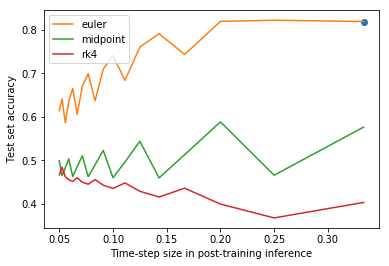

results/odenet_FMNIST_SingleSegment_8_False_rk4_3_0.5_1.pkl


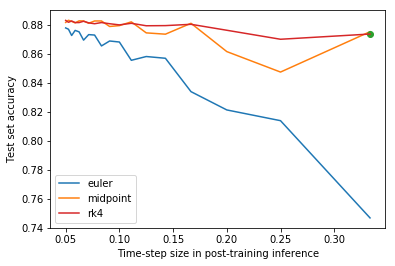

results/odenet_FMNIST_SingleSegment_8_False_midpoint_3_0.5_1.pkl


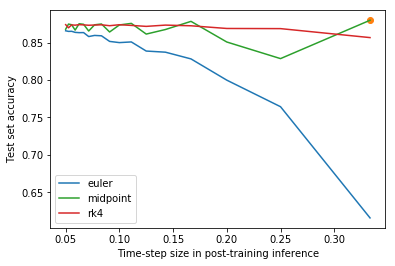

In [44]:
for name, accs_for_scheme in test_sweep.items():
    print(name)
    for scheme, accs in accs_for_scheme.items():
        x,y = zip(*accs)
        if scheme in name:
            plt.plot(1.0/x[0],y[0],'o')
        plt.plot([1.0/_x for _x in x], y, label=scheme)
    plt.legend()
    plt.xlabel('Time-step size in post-training inference')
    plt.ylabel('Test set accuracy')
    plt.show()